# Tests

## Imports and stuff

In [1]:
import sys
from copy import copy

def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)

append_path("..")
%load_ext autoreload
#%autoreload 2

In [2]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import torch
from torch import Tensor


In [3]:
import ml_lib
from ml_lib import feature_specification

Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7a4244cf0790>> (for post_execute):


ValueError: module object for 'ml_lib.datasets.feature_specification' substituted in sys.modules during a lazy load

In [4]:
ls ../ml_lib/datasets

base_classes.py  feature_specification.py  registration.py
datapoint.py     __init__.py               splitting.py
datasets/        __pycache__/              transforms.py


## Datasets

In [5]:
from ml_lib.datasets import register as dataset_register, transform_register, load_transform, load_dataset, Transform
from ml_lib.datasets.transforms import MultipleFunctionTransform

In [6]:
dataset0 = dataset_register["Torus4D"](1000)

In [7]:
transform = transform_register["CacheTransform"]() 
dataset1 = transform(dataset0)

In [8]:
dataset1._inner

In [9]:
dataset1[0]

tensor([[ 1.0025,  0.0483, -1.0075,  0.1324]])

In [10]:
dataset2 = transform_register["RenameTransform"]({"x": "_"})(dataset1)
dataset2[0]

In [11]:
dataset3 = transform_register["RenameTransform"]({"x": "x", "y":"x"})(dataset2)
dataset3[0]

In [12]:
normalize = lambda x : x / x.norm()
dataset4 = transform_register["MultipleFunctionTransform"]({"x": (normalize, "x"), "gt": (lambda x:x, "y")})(dataset3)
dataset4[0]

In [13]:
@transform_register
class TestTransform(MultipleFunctionTransform):

    def __init__(self):
        super().__init__({"x": (normalize, "x"), "gt": (lambda x:x, "y")})

great!

## Environments

In [14]:
from ml_lib.environment import Environment, Scope, scopevar_of_str, str_of_scopevar, HierarchicEnvironment, ScopedEnvironment

In [15]:
scopevar_of_str("a/b/c")

(('a', 'b'), 'c')

In [16]:
str_of_scopevar(('a', 'b'), 'c')

'a/b/c'

In [17]:
env = Environment()

In [18]:
env

Environment(defaultdict(<class 'dict'>, {'_ipython_canary_method_should_not_exist_': {}, '_ipython_display_': {}, '_repr_mimebundle_': {}}))

In [19]:
env.record("hello", 1)

In [20]:
env.data

defaultdict(dict,
            {'_ipython_canary_method_should_not_exist_': {},
             '_ipython_display_': {},
             '_repr_mimebundle_': {},
             '_repr_html_': {},
             '_repr_markdown_': {},
             '_repr_svg_': {},
             '_repr_png_': {},
             '_repr_pdf_': {},
             '_repr_jpeg_': {},
             '_repr_latex_': {},
             '_repr_json_': {},
             '_repr_javascript_': {},
             'hello': {(): 1}})

In [21]:
env.record("world", 4, ("some", "scope"))
env.data

defaultdict(dict,
            {'_ipython_canary_method_should_not_exist_': {},
             '_ipython_display_': {},
             '_repr_mimebundle_': {},
             '_repr_html_': {},
             '_repr_markdown_': {},
             '_repr_svg_': {},
             '_repr_png_': {},
             '_repr_pdf_': {},
             '_repr_jpeg_': {},
             '_repr_latex_': {},
             '_repr_json_': {},
             '_repr_javascript_': {},
             'hello': {(): 1},
             'world': {('some', 'scope'): 4}})

In [22]:
env.get("hello")

1

In [23]:
env.get("world")

4

In [24]:
#import pdb; pdb.set_trace()
env.get("world", scope=("some",))

4

In [25]:
env.get("world", scope=("soe",))

In [26]:
hier_env = HierarchicEnvironment(parent=env)

In [27]:
hier_env.record("world", 2, ("some",))
hier_env.get("world", scope=("some",))


2

In [28]:
hier_env.get("world", scope=("some","scope"))


4

In [29]:
def f(world, hello=6, magic=3):
    print(world, hello, magic)
    return 1

In [30]:
hier_env.run_function(f)

2 1 3


1

## Model

In [31]:
from ml_lib.datasets.feature_specification import FeatureSpecification, MSEFeature

feature_spec = FeatureSpecification([MSEFeature("location", 4)])
assert feature_spec == feature_spec.from_config(feature_spec.to_config())
feature_spec

FeatureSpecification(MSEFeature(name='location', dim=4, loss_coef=1.0))

In [33]:
from ml_lib.models import Model, Supervised, Hyperparameter, register as model_register
from ml_lib.models.layers import MLP

@model_register
class SimpleMLPModel(Supervised):
    
    dimensions: Hyperparameter[list[int]]
    feature_specification: Hyperparameter[FeatureSpecification]
    

    inner: MLP

    def __setup__(self):
        self.inner = MLP(self.feature_specification.dim, *self.dimensions, batchnorm=False)

    def forward(self, x):
        return self.inner(x)

    def loss_fun(self, x, gt):
        return self.feature_specification.compute_loss(x, gt, reduce=True)
        #return (x - gt).square().sum()
        

model = SimpleMLPModel(dimensions=[5, 10, 4, 4],
                       feature_specification=feature_spec, 
                       name="test_model")
print(model)
print(torch.nn.Module.__repr__(model))
model.model_name

SimpleMLPModel(
    dimensions=[5, 10, 4, 4],
    feature_specification=FeatureSpecification(MSEFeature(name='location', dim=4, loss_coef=1.0)),
)
SimpleMLPModel(
  (inner): MLP(
    (linear_0): Linear(in_features=4, out_features=5, bias=True)
    (activation_0): ReLU()
    (linear_1): Linear(in_features=5, out_features=10, bias=True)
    (activation_1): ReLU()
    (linear_2): Linear(in_features=10, out_features=4, bias=True)
    (activation_2): ReLU()
    (linear_3): Linear(in_features=4, out_features=4, bias=True)
  )
)


'test_model'

In [34]:
model.get_hyperparameters(serializable=True)

{'dimensions': [5, 10, 4, 4],
 'feature_specification': {'type': 'FeatureSpecification',
  'features': [{'type': 'MSEFeature',
    'name': 'location',
    'dim': 4,
    'loss_coef': 1.0}]}}

## Saving and loading to database

In [35]:
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from ml_lib.pipeline.experiment_tracking import create_tables, Model as Database_Model


In [36]:
model.get_model_type()

'SimpleMLPModel'

In [37]:
model.to_database_object()

Model(id= None, model_type= SimpleMLPModel, name= test_model, description= None)

In [38]:
print_requests = False
%rm /tmp/test.db
db_engine = create_engine("sqlite:////tmp/test.db", echo=print_requests)
create_tables(db_engine)
with Session(db_engine) as db_session:
    model.save_to_database(db_session, replace=True)
    #db_session.commit()
    print(model.get_database_object(db_session))
    model_object  = db_session.get(Database_Model, model.id)
    db_session.commit()
model.id

Model(id= 1, model_type= SimpleMLPModel, name= test_model, description= None)


1

In [39]:
with Session(db_engine) as db_session:
    model_object  = db_session.get(Database_Model, model.id)
    print(model_object)
    print(type(db_session))
    loaded_model= model_object.load_model(load_latest_checkpoint=False,) #cannot load checkpoint for now since there isn't one
loaded_model

Model(id= 1, model_type= SimpleMLPModel, name= test_model, description= None)
<class 'sqlalchemy.orm.session.Session'>


SimpleMLPModel(
    dimensions=[5, 10, 4, 4],
    feature_specification=FeatureSpecification(MSEFeature(name='location', dim=4, loss_coef=1.0)),
)

## Training

In [40]:
skip_training = False

In [41]:
from ml_lib.models import Model
from ml_lib.pipeline import Trainer, Training_parameters
from ml_lib.pipeline.training_hooks import TqdmHook, LoggerHook, CurveHook, DatabaseHook
from ml_lib.pipeline.experiment_tracking import Experiment as DBExperiment
from torch.utils.data import DataLoader

In [42]:
loader = DataLoader(dataset4, batch_size=None, shuffle=True)
next(iter(loader))

Epoch 0:   0%|          | 0/4000 [00:00<?, ?it/s]

INFO:root:iteration= 0, loss= 0.618953287601471, 
INFO:root:iteration= 10, loss= 0.652764081954956, 
INFO:root:iteration= 20, loss= 0.573591411113739, 
INFO:root:iteration= 30, loss= 0.44183504581451416, 
INFO:root:iteration= 40, loss= 0.8669790625572205, 
INFO:root:iteration= 50, loss= 0.6705443263053894, 
INFO:root:iteration= 60, loss= 0.7512810826301575, 
INFO:root:iteration= 70, loss= 0.645828366279602, 
INFO:root:iteration= 80, loss= 0.7297670245170593, 
INFO:root:iteration= 90, loss= 0.39146241545677185, 
/home/tris/Devoirs/research/implementations/tb_ml/ml_lib/models/base_classes.py:351: SAWarning: Object of type <Training_step> not in session, add operation along 'Training_run.steps' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  db_object = session.get(Database_Model, self.id)
INFO:root:iteration= 100, loss= 0.2802296280860901, 
INFO:root:iteration= 110, loss= 0.72762

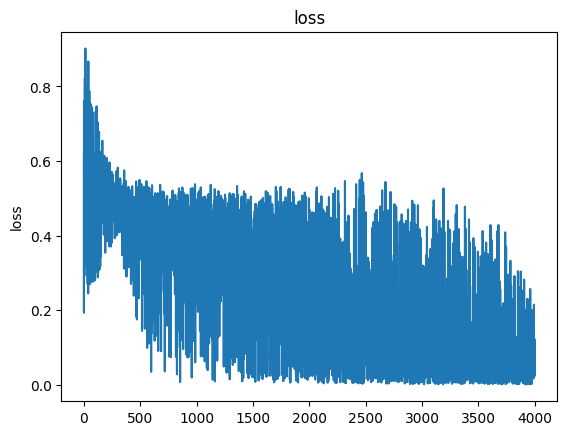

In [43]:
import logging; logging.basicConfig(level=logging.INFO, force=True)

curve = CurveHook()
training_parameters = Training_parameters(n_epochs=4)

with Session(db_engine) as db_session:
    experiment = DBExperiment(name="test_experiment", )
    db_session.add(experiment)
    trainer = Trainer(model, loader, training_parameters=training_parameters, device="cpu",
        step_hooks = [ 
            TqdmHook(),
            LoggerHook(interval=10),
            curve
        ],
        database=db_session, 
        db_experiment=experiment, )
    experiment_id = experiment.id
    trainer_id = trainer.id
    if not skip_training: trainer.train()
curve.draw()

Now check that we're able to resume training

In [44]:
new_training_parameters = copy(training_parameters)
new_training_parameters.n_epochs = 5
with Session(db_engine) as db_session:
    
    trainer = Trainer(model, loader, 
                      training_parameters=training_parameters, device="cpu",
        step_hooks = [ 
            TqdmHook(),
            LoggerHook(interval=10),
            curve
        ],
        database=db_session, 
        db_experiment=experiment_id, 
        resume_from=trainer_id)
    if not skip_training: trainer.train()

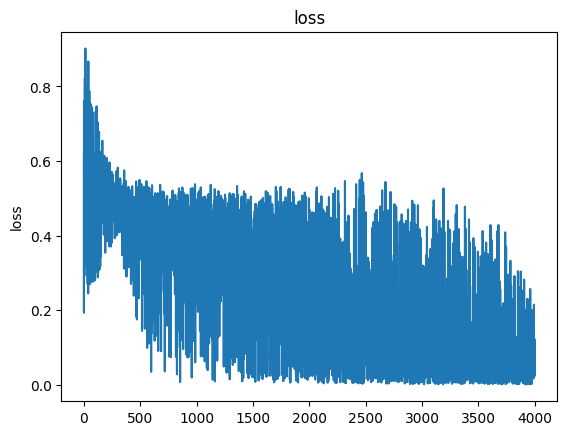

In [45]:
curve.draw()

## Automated experiment

In [46]:
cat workdir/test_config.yaml


models:
  - name: test_model1
    type: SimpleMLPModel
    params:
      dimensions: [4, 5, 10, 4]
    training_parameters:
      n_epochs: 2
      performance_tricks: False
      step_hooks:
        - LoggerHook
      batch_size: 10
datasets:
  train:
    type: Torus4D
    params:
      size: 1000
    transforms: 
      - CacheTransform
      - type: RenameTransform
        args: 
          - x: _
      - type: RenameTransform
        args:
          - x: x
            y: x
      - TestTransform


In [47]:
from ml_lib.pipeline.experiment import Experiment
with Session(db_engine) as db_session:
    #import pdb;pdb.set_trace()
    exp = Experiment.from_yaml("workdir/test_config.yaml", database_session=db_session)
    exp.train_all()

ValueError: Missing hyperparameter feature_specification, and no default value is set

In [ ]:
with Session(db_engine) as db_session:
    #import pdb;pdb.set_trace()
    exp = Experiment.from_yaml("workdir/test_config.yaml", database_session=db_session)
    exp.train_all()

## Misc

In [ ]:
from ml_lib.misc.matchers import EmptySet

In [ ]:
isinstance(set(), EmptySet)

In [ ]:
isinstance(set([1]), EmptySet)

In [ ]:
match set():
    case EmptySet():
        print("Tristan, you are a terrible person")
    case _:
        print("ugh")

match {1, 2, 3}:
    case EmptySet():
        print("ugh")
    case _:
        print("But it works")

Someday I'll make one of those that checks for regular expressions… and that will be absolutely terrible